In [1]:
import os
from fair import FAIR
from fair.io import read_properties
from fair.interface import initialise
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

/Users/bensan/explore-extensions/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f = FAIR()

In [3]:
snames=["high-extension", "high-overshoot", "medium-extension", "medium-overshoot", "low", "verylow", "verylow-overshoot"]
snames_short=["H-ext","H-ext-OS","M-ext","ML-ext","L-ext","VLLO-ext","VLHO-ext"]
sname21_short=["H","H","M","ML","L","VLLO","VLHO"]


f.define_time(1750, 2501, 1)
f.define_scenarios(snames)
species, properties = read_properties('../data/fair-parameters/species_configs_properties_1.4.1.csv')
f.define_species(species, properties)
f.ch4_method='Thornhill2021'
df_configs = pd.read_csv('../data/fair-parameters/calibrated_constrained_parameters_1.4.1.csv', index_col=0)
f.define_configs(df_configs.index)
f.allocate()

In [4]:
scens=f.emissions.scenario.values

In [5]:
ldict={}
ldict21={}
for i,s in enumerate(snames):
    ldict[s]=snames_short[i]
    ldict21[s]=sname21_short[i]


In [6]:
colors = {
    snames[0]: '#800000',
    snames[1]: '#ff0000',
    snames[2]: '#fc7b03',
    snames[3]: '#d3a640',
    snames[4]: '#098740',
    snames[5]: '#0080d0',
    snames[6]: '#100060',
}

In [7]:
os.makedirs('../plots', exist_ok=True)

In [8]:
df_emis = pd.read_csv('../data/emissions/extensions_1750-2500.csv')
gwpmat=df_emis.loc[df_emis.scenario=='verylow-overshoot'].set_index('variable')['ar6_gwp_mass_adjusted']

In [9]:
ch4dict={}
ch4dict[scens[0]]=[[2200,2250],[np.nan,50]] # H-ext
ch4dict[scens[1]]=[[2100,2200],[np.nan,50]] # H-ext-OS
ch4dict[scens[2]]=[[2300],[np.nan]]#    M-ext
ch4dict[scens[3]]=[[2040,2050,2060,2125,2150,2300],[np.nan,350,300,170,120,120]]#    MOS-ext
#ch4dict[scens[4]]=[[2300],[np.nan]]#    L-ext
ch4dict[scens[4]]=[[2025,2030,2040,2050,2060,2080,2090,2100,2125,2300],[np.nan,260,200,150,110,100,95,95,95,95]]#    VL-ext
ch4dict[scens[5]]=[[2025,2030,2040,2050,2060,2080,2090,2100,2125,2300],[np.nan,260,150,120,100,95,90,90,90,90]]#    VL-ext
ch4dict[scens[6]]=[[2025,2030,2050,2060,2100,2300],[np.nan,360,300,170,120,120]]#    L-ext-OS

In [10]:
n2odict={}
n2odict[scens[0]]=[[2200,2250],[np.nan,6]] # H-ext
n2odict[scens[1]]=[[2100,2200],[np.nan,6]] # H-ext-OS
n2odict[scens[2]]=[[2300],[np.nan]] #    M-ext
n2odict[scens[3]]=[[2300],[np.nan]]     #    MOS-ext
n2odict[scens[4]]=[[2300],[np.nan]]   #    L-ext
n2odict[scens[5]]=[[2300],[np.nan]]  #    VL-ext
n2odict[scens[6]]=[[2100,2200],[np.nan,2]] #    L-ext-OS

In [11]:
sulfdict={}
sulfdict[scens[0]]=[[2300],[np.nan]] # H-ext
sulfdict[scens[1]]=[[2100,2150],[np.nan,10]] # H-ext-OS
sulfdict[scens[2]]=[[2300],[np.nan]] #    M-ext
sulfdict[scens[3]]=[[2040,2050,2100],[np.nan,24,10]]     #    MOS-ext
sulfdict[scens[4]]=[[2300],[np.nan]]   #    L-ext
sulfdict[scens[5]]=[[2300],[np.nan]]  #    VL-ext
sulfdict[scens[6]]=[[2025,2030,2040,2050,2100],[np.nan,60,45,24,10]] #    L-ext-OS

In [12]:
f.fill_from_csv(
    emissions_file='../data/emissions/extensions_1750-2500.csv',
    forcing_file='../data/forcing/volcanic_solar.csv',
)

In [13]:
f.emissions.sel(scenario='high-extension').loc[:]=f.emissions.sel(scenario='high-overshoot').copy()

In [14]:

for s in scens:
    corescen=f.emissions.sel(scenario=s, specie='CH4',config=1234).where(f.emissions.timepoints<=ch4dict[s][0][0], drop=True)
    histtim=f.emissions.timepoints.where(f.emissions.timepoints<=ch4dict[s][0][0], drop=True)
    tmpf=f.emissions.sel(scenario=s, specie='CH4',config=1234).copy()
    tmpf[:]=(f.emissions.timepoints,np.interp(f.emissions.timepoints,np.hstack([histtim,ch4dict[s][0][1:]]),np.hstack([corescen,ch4dict[s][1][1:]])))[1]
    f.emissions.sel(scenario=s, specie='CH4').loc[:,:]=tmpf
for s in scens:
    corescen=f.emissions.sel(scenario=s, specie='N2O',config=1234).where(f.emissions.timepoints<=n2odict[s][0][0], drop=True)
    histtim=f.emissions.timepoints.where(f.emissions.timepoints<=n2odict[s][0][0], drop=True)
    tmpf=f.emissions.sel(scenario=s, specie='N2O',config=1234).copy()
    tmpf[:]=(f.emissions.timepoints,np.interp(f.emissions.timepoints,np.hstack([histtim,n2odict[s][0][1:]]),np.hstack([corescen,n2odict[s][1][1:]])))[1]
    f.emissions.sel(scenario=s, specie='N2O').loc[:,:]=tmpf
for s in scens:
    corescen=f.emissions.sel(scenario=s, specie='Sulfur',config=1234).where(f.emissions.timepoints<=sulfdict[s][0][0], drop=True)
    histtim=f.emissions.timepoints.where(f.emissions.timepoints<=sulfdict[s][0][0], drop=True)
    tmpf=f.emissions.sel(scenario=s, specie='Sulfur',config=1234).copy()
    tmpf[:]=(f.emissions.timepoints,np.interp(f.emissions.timepoints,np.hstack([histtim,sulfdict[s][0][1:]]),np.hstack([corescen,sulfdict[s][1][1:]])))[1]
    f.emissions.sel(scenario=s, specie='Sulfur').loc[:,:]=tmpf

In [15]:
gwp_nonco2=gwpmat.copy()
gwp_nonco2.loc['CO2 AFOLU']=np.nan
gwp_nonco2.loc['CO2 FFI']=np.nan


In [16]:
nonco2=f.emissions.sel(specie='CO2 FFI')[:,:,0].copy()
for specie in f.emissions.specie.values:
   try: 
     gwp=gwp_nonco2[specie]
   except:
     gwp=np.nan
   if ~np.isnan(gwp):
      nonco2=nonco2+f.emissions.sel(specie=specie)[:,:,0]*gwp
   else:
      0  


In [17]:
ncflr=np.ones(len(scens))
for i in range(len(scens)):
    ncflr[i]=nonco2.sel(scenario=scens[i])[-1]/1e6
ncflr

array([3.03301742, 3.03301742, 5.36208637, 5.30342398, 4.52187722,
       4.37835881, 3.89403174])

In [18]:
f.emissions.sel(scenario='high-overshoot', specie='CO2',config=1234,timepoints=np.array([2030,2040,2050,2075,2100,2125])+.5)

<xarray.DataArray (timepoints: 6)> Size: 48B
array([nan, nan, nan, nan, nan, nan])
Coordinates:
  * timepoints  (timepoints) float64 48B 2.03e+03 2.04e+03 ... 2.1e+03 2.126e+03
    scenario    <U17 68B 'high-overshoot'
    config      int64 8B 1234
    specie      <U43 172B 'CO2'

In [19]:
sdict={}
sdict[scens[0]]=[[2025,2030,2040,2050,2075,2100,2175,2275],[np.nan,43, 50, 57.5, 68 , 74,
       74,0]] # H-ext
sdict[scens[1]]=[[2025,2030,2040,2050,2075,2100,2160,2200,2350,2400],[np.nan,43, 50, 57.5, 68 , 74,
       0,-34,-34,0]]# H-ext-OS
#sdict[scens[2]]=[[2125,2200],[np.NaN,0]]# M-ext
sdict[scens[2]]=[[2025,2030,2100,2200],[np.nan,41,41,0]]# M-ext
#sdict[scens[3]]=[[2025,2030,2040,2050,2074,2110,2250,2275],[np.NaN,44,44,10,-3,-13,-13,-ncflr[3]]]# MOS-ext

sdict[scens[3]]=[[2025,2030,2040,2050,2060,2100,2125,2275,2300],[np.nan,41,41,38,32,0,-13,-13,0]]# MOS-ext
#sdict[scens[4]]=[[2025,2030,2040,2050,2080,2100,2240,2290],[np.nan,40,35,25,0,-7,-7,0]]# L-ext
sdict[scens[4]]=[[2025,2030,2040,2050,2080,2100,2240,2290],[np.nan,42.5,38,22,-1,-7,-7,0]]# L-ext
sdict[scens[5]]=[[2025,2030,2040,2050,2060,2070,2080,2090,2100,2125,2225,2275,2300],[np.nan,37.5,15,2,-3,-4.5,-5,-5,-5,-5,-5,-5,0]]# VL-ext

#sdict[scens[6]]=[[2125,2150,2250,2275],[np.NaN,-25,-25,0]]# L-ext-OS
sdict[scens[6]]=[[2025,2030,2040,2050,2065,2100,2150,2200,2250],[np.nan,42.5,37.5,6,-8,-24,-30,-30,0]]# L-ext-OS




In [20]:

for s in scens:
    corescen=(f.emissions.sel(scenario=s, specie='CO2 FFI',config=1234)+f.emissions.sel(scenario=s, specie='CO2 AFOLU',config=1234)).where(f.emissions.timepoints<=sdict[s][0][0], drop=True)
    corelu=f.emissions.sel(scenario=s, specie='CO2 AFOLU',config=1234)
    histtim=f.emissions.timepoints.where(f.emissions.timepoints<=sdict[s][0][0], drop=True)
    tmpf=f.emissions.sel(scenario=s, specie='CO2 FFI',config=1234).copy()
    tmpf[:]=(f.emissions.timepoints,np.interp(f.emissions.timepoints,np.hstack([histtim,sdict[s][0][1:]]),np.hstack([corescen,sdict[s][1][1:]])))[1]
    
    f.emissions.sel(scenario=s, specie='CO2 FFI').loc[:,:]=tmpf-corelu

blending for 4 years, starting with 2022

In [21]:
cyrs=4
cfx=2022.5
bstrt=f.emissions.sel(timepoints=cfx).copy()

for i in np.arange(0,cyrs):
    yr=cfx+i
    f.emissions.loc[dict(timepoints=yr)]=bstrt

byrs=5
bfx=2025.5
for i in np.arange(0,byrs):
    yr=bfx+i
    e_org=f.emissions.loc[dict(timepoints=yr)].copy()
    f.emissions.loc[dict(timepoints=yr)]=bstrt*(1-i/byrs)+e_org*(i/byrs)



(2000.0, 2300.0)

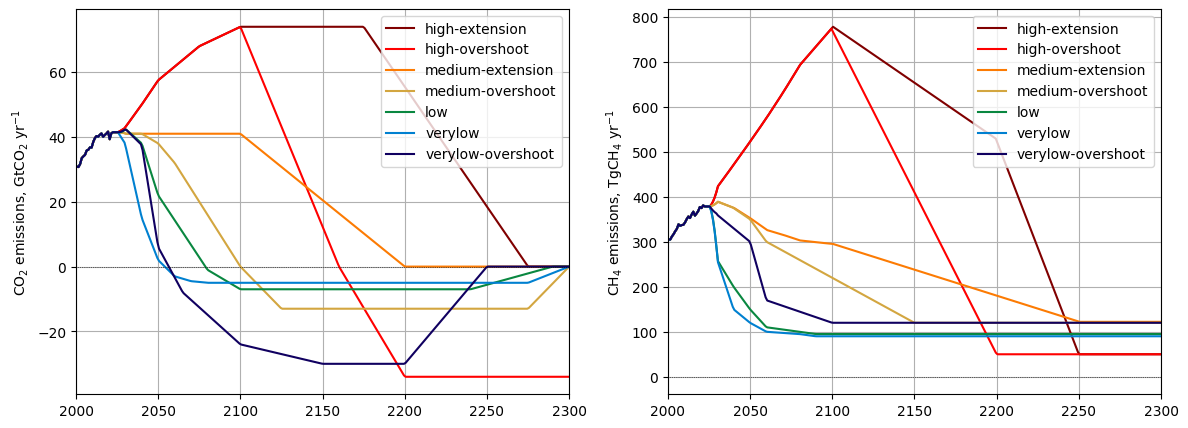

In [22]:
fig, ax = pl.subplots(nrows=1,ncols=2,figsize=(14,5))
for scenario in f.scenarios:
    ax[0].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ),
        label=scenario,
        color=colors[scenario]
    )
ax[0].set_ylabel("CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
ax[0].legend()
ax[0].grid()
ax[0].set_xlim(2000,2300)
for scenario in f.scenarios:
    ax[1].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CH4", config=f.configs[0]) 
        ),
        label=scenario,
        color=colors[scenario]
    )
ax[1].set_ylabel("CH$_4$ emissions, TgCH$_4$ yr$^{-1}$")
ax[1].axhline(ls=':', color='k', lw=0.5)
ax[1].legend()
ax[1].grid()
ax[1].set_xlim(2000,2300)



In [23]:
for s in f.scenarios:
    f.forcing.loc[dict(scenario=s,specie='Solar')]=0


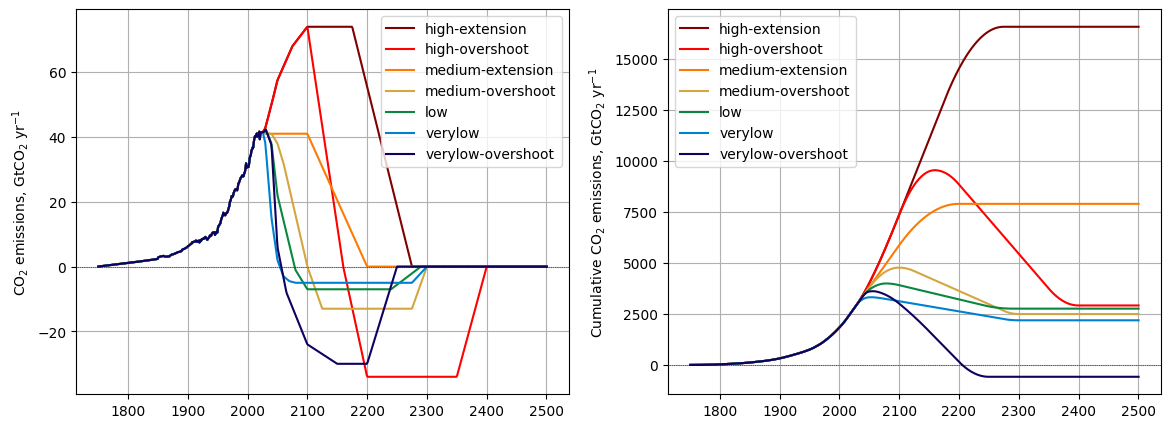

In [24]:
fig, ax = pl.subplots(nrows=1,ncols=2,figsize=(14,5))
for scenario in f.scenarios:
    ax[0].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ),
        label=scenario,
        color=colors[scenario]
    )
ax[0].set_ylabel("CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
ax[0].legend()
ax[0].grid()
for scenario in f.scenarios:
    ax[1].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ).cumsum(),
        label=scenario,
        color=colors[scenario]
    )
ax[1].set_ylabel("Cumulative CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[1].axhline(ls=':', color='k', lw=0.5)
ax[1].legend()
ax[1].grid()
pl.savefig('../plots/co2_emissions.png')

In [25]:
# dump out emissions
os.makedirs('../output/', exist_ok=True)
scens_out = []
for s in scens:
    df_scen = f.emissions.sel(scenario=s, config=1234).to_pandas().T
    df_scen.insert(loc=0, column='Scenario', value=s)
    df_scen.dropna(inplace=True)
    scens_out.append(df_scen)
scens_out = pd.concat(scens_out)
scens_out.to_csv('../output/emissions_adjusted.csv')

Calculate CO2e

In [26]:
co2eo=f.emissions.sel(specie='CO2 FFI')[:,:,0].copy()
for specie in f.emissions.specie.values:
   try: 
     gwp=gwpmat[specie]
   except:
     gwp=np.nan
   if ~np.isnan(gwp):
      co2eo=co2eo+f.emissions.sel(specie=specie)[:,:,0]*gwp
   else:
      0  


Bias correct co2e

In [27]:
gwpmat

variable
BC                    NaN
C2F6             12400.00
C3F8              9290.00
C4F10            10000.00
C5F12             9220.00
C6F14             8620.00
C7F16             8410.00
C8F18             8260.00
CCl4              2200.00
CF4               7380.00
CFC-11            6230.00
CFC-113           6520.00
CFC-114           9430.00
CFC-115           9600.00
CFC-12           12500.00
CH2Cl2              11.20
CH3Br                2.43
CH3CCl3            161.00
CH3Cl                5.54
CH4              27900.00
CHCl3               20.60
CO                    NaN
CO2 AFOLU      1000000.00
CO2 FFI        1000000.00
HCFC-141b          860.00
HCFC-142b         2300.00
HCFC-22           1960.00
HFC-125           3740.00
HFC-134a          1530.00
HFC-143a          5810.00
HFC-152a           164.00
HFC-227ea         3600.00
HFC-23           14600.00
HFC-236fa         8690.00
HFC-245fa          962.00
HFC-32             771.00
HFC-365mfc         914.00
HFC-4310mee       1600.00
Hal

In [28]:
co2e=co2eo#-co2eo.loc[dict(timepoints=2019.5)].values+53.e6

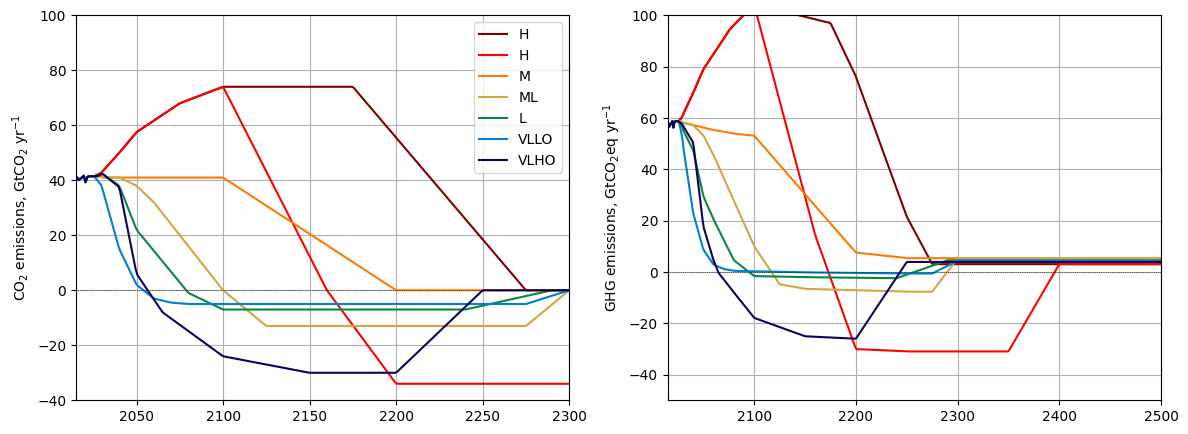

In [29]:
fig, ax = pl.subplots(1,2,figsize=(14,5))
for scenario in f.scenarios:
    ax[0].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[0].set_ylabel("CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
ax[0].set_xlim(2015,2300)
ax[0].set_ylim(-40,100)

ax[0].legend()
ax[0].grid()

for scenario in f.scenarios:
    ax[1].plot(
        f.timepoints,
        co2e.sel(scenario=scenario)/ 1e6,
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[1].set_ylabel("GHG emissions, GtCO$_2$eq yr$^{-1}$")
ax[1].axhline(ls=':', color='k', lw=0.5)
#ax[1].legend()
ax[1].set_xlim(2015,2500)
ax[1].set_ylim(-50,100)

ax[1].grid()
pl.savefig('../plots/ghg_emissions.png')

In [30]:
f.fill_species_configs('../data/fair-parameters/species_configs_properties_1.4.1.csv')
f.override_defaults('../data/fair-parameters/calibrated_constrained_parameters_1.4.1.csv')
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)
f.run()

Running 5887 projections in parallel: 100%|██████████| 751/751 [01:01<00:00, 12.31timesteps/s]


In [40]:
f.forcing.sel(scenario=nohos[1], specie='Solar')

<xarray.DataArray (timebounds: 752, config: 841)> Size: 5MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * timebounds  (timebounds) float64 6kB 1.75e+03 1.751e+03 ... 2.501e+03
    scenario    <U17 68B 'medium-extension'
  * config      (config) int64 7kB 1234 2451 5859 ... 1592589 1594247 1597937
    specie      <U43 172B 'Solar'

In [31]:
nohos=[x for x in f.scenarios if x != "high-overshoot"] 

In [32]:
co2e

<xarray.DataArray (timepoints: 751, scenario: 7)> Size: 42kB
array([[1391771.78832032, 1391771.78832032, 1391771.78832032, ...,
        1391771.78832032, 1391771.78832032, 1391771.78832032],
       [1406987.83040189, 1406987.83040189, 1406987.83040189, ...,
        1406987.83040189, 1406987.83040189, 1406987.83040189],
       [1427461.48199987, 1427461.48199987, 1427461.48199987, ...,
        1427461.48199987, 1427461.48199987, 1427461.48199987],
       ...,
       [3033033.23737114, 3033033.23737114, 5362086.37265614, ...,
        4521881.01958414, 4378362.54721714, 3894033.23737114],
       [3033033.23737114, 3033033.23737114, 5362086.37265614, ...,
        4521881.01958414, 4378362.54721714, 3894033.23737114],
       [3033033.23737114, 3033033.23737114, 5362086.37265614, ...,
        4521881.01958414, 4378362.54721714, 3894033.23737114]])
Coordinates:
  * timepoints  (timepoints) float64 6kB 1.75e+03 1.752e+03 ... 2.5e+03 2.5e+03
  * scenario    (scenario) <U17 476B 'high-extension' ... 'verylow-overshoot'
    config      int64 8B 1234

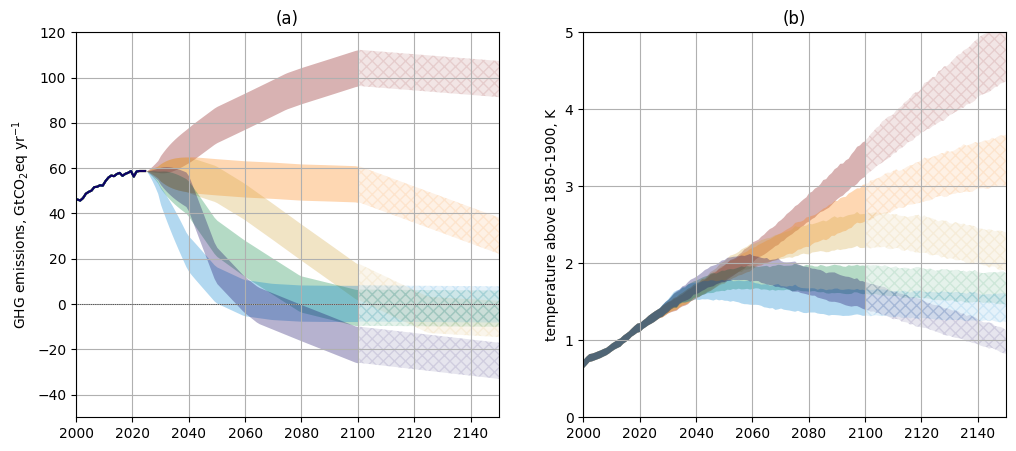

In [35]:
fig, ax = pl.subplots(1,2,figsize=(12,5))

unc=np.tanh((co2e.sel(scenario=nohos[0])-co2e.sel(scenario=nohos[-1]))/1e6/10)*8
for scenario in nohos:
    
    ax[0].fill_between(
        f.timebounds[:351],
        co2e.sel(scenario=scenario)[:351]/1e6-unc[:351],
        co2e.sel(scenario=scenario)[:351]/1e6+unc[:351],
        color=colors[scenario],
        lw=0,
        alpha=0.3
    )
    ax[0].fill_between(
        f.timepoints[350:],
        co2e.sel(scenario=scenario)[350:]/1e6-unc[350:],
        co2e.sel(scenario=scenario)[350:]/1e6+unc[350:],
        color=colors[scenario],hatch='XXX',
        lw=0,
        alpha=0.1
    )
    ax[0].plot(
         f.timepoints[:275],
         co2e.sel(scenario=scenario)[:275]/ 1e6,
         label=ldict21[scenario],
         color=colors[scenario]
     )
    # ax[0].plot(
    #     f.timepoints[350:],
    #     co2e.sel(scenario=scenario)[350:]/ 1e6,
    #     label=ldict21[scenario],
    #     color=colors[scenario],linestyle='--'
    # )

ax[0].set_ylabel("GHG emissions, GtCO$_2$eq yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
#ax[1].legend()
ax[0].set_xlim(2000,2150)
ax[0].set_ylim(-50,120)

ax[0].grid()
ax[0].set_title('(a)')

for scenario in nohos:
    ax[1].fill_between(
        f.timebounds[:351],
        (
            f.temperature.sel(scenario=scenario, layer=0)[:351]-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.33, dim='config'),
        (
            f.temperature.sel(scenario=scenario, layer=0)[:351]-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.66, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.3
    )
    ax[1].fill_between(
        f.timebounds[350:],
        (
            f.temperature.sel(scenario=scenario, layer=0)[350:]-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.33, dim='config'),
        (
            f.temperature.sel(scenario=scenario, layer=0)[350:]-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.66, dim='config'),
        color=colors[scenario],hatch='XXX',
        lw=0,
        alpha=0.1
    )
    # ax[1].fill_between(
    #     f.timebounds,
    #     (
    #         f.temperature.sel(scenario=scenario, layer=0)-
    #         f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
    #     ).quantile(0.25, dim='config'),
    #     (
    #         f.temperature.sel(scenario=scenario, layer=0)-
    #         f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
    #     ).quantile(0.75, dim='config'),
    #     color=colors[scenario],
    #     lw=0,
    #     alpha=0.1
    # )
    # ax[1].plot(
    #     f.timebounds[:350],
    #     (
    #         f.temperature.sel(scenario=scenario, layer=0)-
    #         f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
    #     ).median(dim='config')[:350],
    #     label=ldict21[scenario],
    #     color=colors[scenario]
    # )
    # ax[1].plot(
    #     f.timebounds[350:],
    #     (
    #         f.temperature.sel(scenario=scenario, layer=0)-
    #         f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
    #     ).median(dim='config')[350:],
    #     label=ldict21[scenario],linestyle='--',
    #     color=colors[scenario]
    # )
ax[1].axhline(0, ls=':', color='k', lw=0.5)
ax[1].set_ylabel('temperature above 1850-1900, K')
ax[1].set_ylim(0, 5)
ax[1].set_xlim(2000,2150)

ax[1].grid()
#ax[2].legend();

ax[1].set_title('(b)')
pl.savefig('../plots/temperature_emis.png')

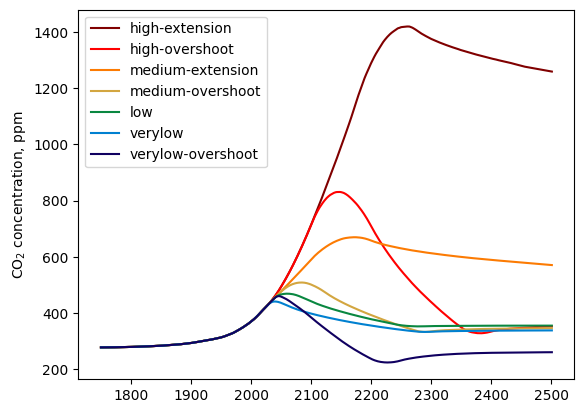

In [42]:
fig, ax = pl.subplots()
for scenario in f.scenarios:
    ax.plot(
        f.timebounds,
        f.concentration.sel(scenario=scenario, specie="CO2").median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax.set_ylabel('CO$_2$ concentration, ppm')
pl.legend();
pl.savefig('../plots/co2_concentration.png')

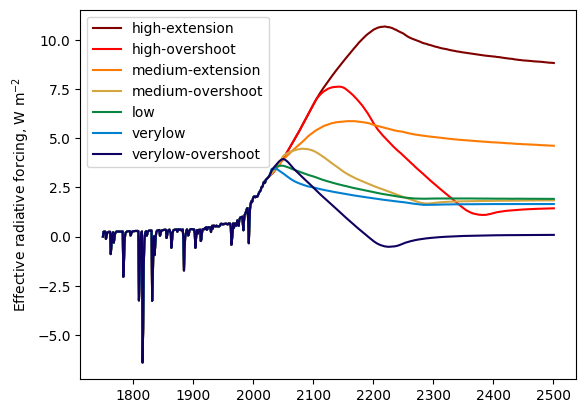

In [43]:
fig, ax = pl.subplots()
for scenario in f.scenarios:
    pl.plot(
        f.timebounds,
        f.forcing_sum.sel(scenario=scenario).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax.set_ylabel('Effective radiative forcing, W m$^{-2}$')
pl.legend();
pl.savefig('../plots/forcing.png')

In [44]:
# year 2100 forcing check
f.forcing_sum.sel(timebounds=2100).median(dim='config')

<xarray.DataArray (scenario: 7)> Size: 56B
array([6.69867369, 6.69867369, 5.30522638, 4.37249374, 3.06846671,
       2.50652552, 2.51056645])
Coordinates:
    timebounds  float64 8B 2.1e+03
  * scenario    (scenario) <U17 476B 'high-extension' ... 'verylow-overshoot'

In [45]:
(
    f.temperature.sel(timebounds=2100, layer=0)-
    f.temperature.sel(layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
).median(dim='config')

<xarray.DataArray (scenario: 7)> Size: 56B
array([3.37590464, 3.37590464, 2.7859573 , 2.42319656, 1.78111805,
       1.50323254, 1.58488573])
Coordinates:
    timebounds  float64 8B 2.1e+03
  * scenario    (scenario) <U17 476B 'high-extension' ... 'verylow-overshoot'
    layer       int64 8B 0

In [46]:
# ozone
f.forcing.sel(timebounds=2100, specie='Ozone').median(dim='config')

<xarray.DataArray (scenario: 7)> Size: 56B
array([0.79745055, 0.79745055, 0.36764516, 0.31668083, 0.12260795,
       0.12275054, 0.18181321])
Coordinates:
    timebounds  float64 8B 2.1e+03
  * scenario    (scenario) <U17 476B 'high-extension' ... 'verylow-overshoot'
    specie      <U43 172B 'Ozone'

In [47]:
# check all the forcings we expect are present
for specie in f.species:
    print(specie, f.forcing.sel(timebounds=2100, scenario=f.scenarios[0], specie=specie).median(dim='config').data)

CO2 FFI nan
CO2 AFOLU nan
CO2 5.29668648961328
CH4 0.9313302726576084
N2O 0.4502023162697577
Sulfur nan
BC nan
OC nan
NH3 nan
NOx nan
VOC nan
CO nan
CFC-11 0.025371004414515452
CFC-12 0.09732379813803292
CFC-113 0.010881409300495632
CFC-114 0.004358029770411637
CFC-115 0.002520596048180414
HCFC-22 0.00022585268809626003
HCFC-141b 0.00017768630794784358
HCFC-142b 0.00045788557047746534
CCl4 0.0019994736107529264
CHCl3 7.018380774912529e-05
CH2Cl2 0.0013666893852824628
CH3Cl 0.00023183645615020045
CH3CCl3 2.825630223734934e-06
CH3Br -4.932518297142732e-07
Halon-1211 0.00015125900197595358
Halon-1301 0.0007845607542810934
Halon-2402 2.4304129681096322e-05
CF4 0.007830301379690416
C2F6 0.0016645510892525233
C3F8 0.00023508504395853224
c-C4F8 0.000995047136713901
C4F10 8.583279120593138e-05
C5F12 6.544742467383753e-05
C6F14 0.00015433947215487873
C7F16 3.478675362863958e-05
C8F18 3.062702212329408e-05
NF3 0.0020566320406267624
SF6 0.023862075294478025
SO2F2 0.0007327450690673869
HFC-125 0.0

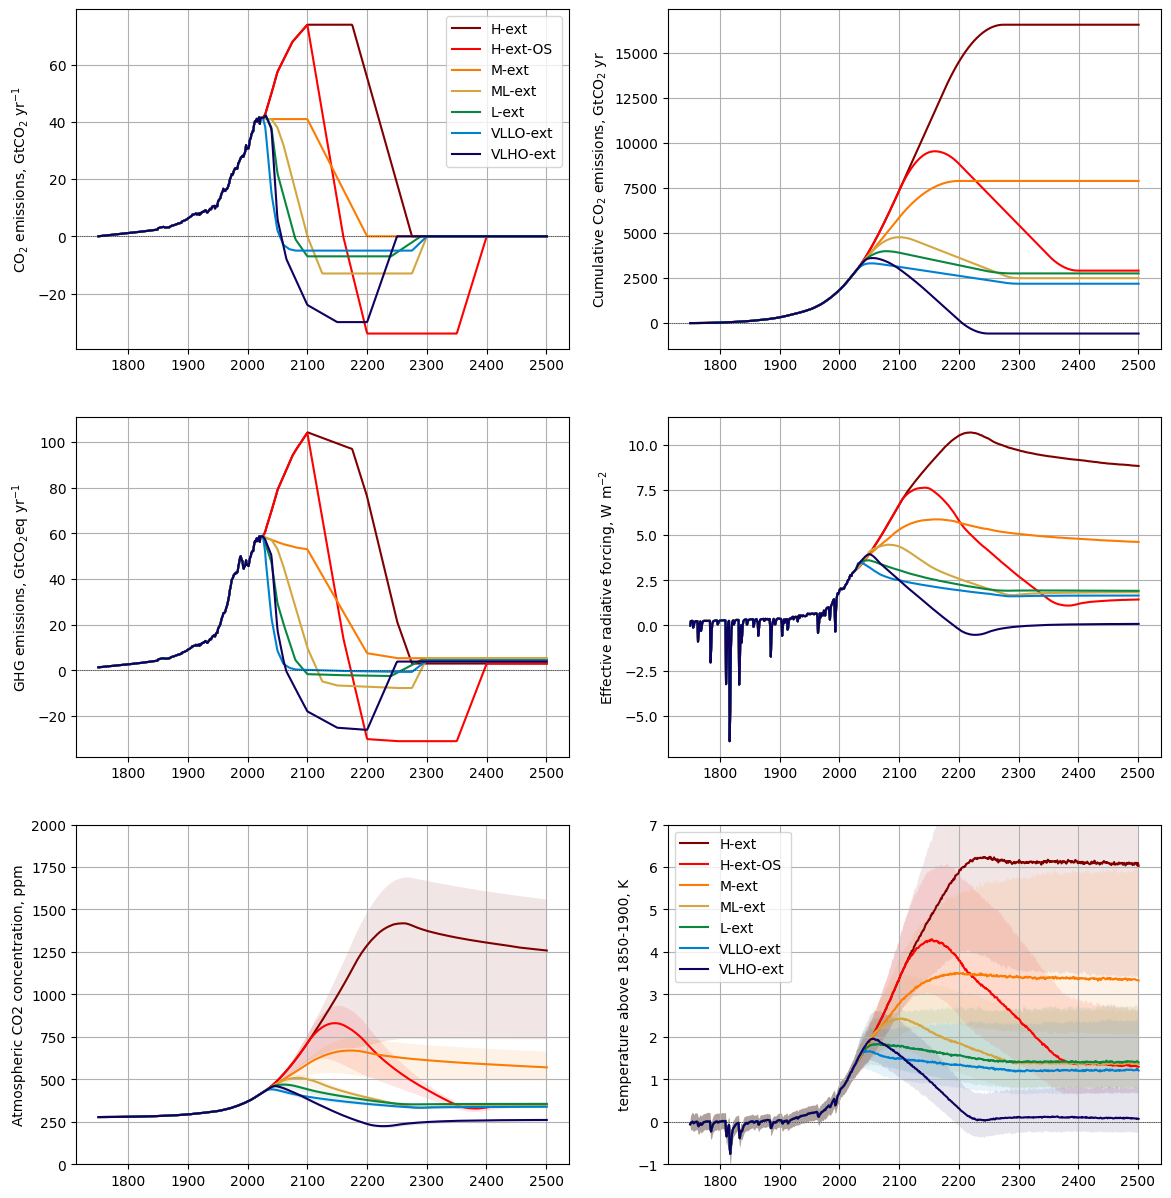

In [48]:
fig, ax = pl.subplots(nrows=3,ncols=2,figsize=(14,15))
ax=ax.flatten()
for scenario in f.scenarios:
    ax[0].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ),
        label=ldict[scenario],
        color=colors[scenario]
    )
ax[0].set_ylabel("CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
ax[0].legend()
ax[0].grid()
for scenario in f.scenarios:
    ax[1].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ).cumsum(),
        label=scenario,
        color=colors[scenario]
    )
ax[1].set_ylabel("Cumulative CO$_2$ emissions, GtCO$_2$ yr")
ax[1].axhline(ls=':', color='k', lw=0.5)
#ax[1].legend()
ax[1].grid()

for scenario in f.scenarios:
    ax[2].plot(
        f.timepoints,
        co2e.sel(scenario=scenario)/ 1e6,
        label=scenario,
        color=colors[scenario]
    )
ax[2].set_ylabel("GHG emissions, GtCO$_2$eq yr$^{-1}$")
ax[2].axhline(ls=':', color='k', lw=0.5)
#ax[2].legend()
ax[2].grid()

for scenario in f.scenarios:
    ax[3].plot(
        f.timebounds,
        f.forcing_sum.sel(scenario=scenario).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax[3].set_ylabel('Effective radiative forcing, W m$^{-2}$')
#pl.legend();
ax[3].grid()

for scenario in f.scenarios:
    ax[4].fill_between(
        f.timebounds,
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario, )
        ).quantile(0.05, dim='config'),
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario)
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.1
    )
    ax[4].plot(
        f.timebounds,
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario)
        ).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax[4].axhline(0, ls=':', color='k', lw=0.5)
ax[4].set_ylabel('Atmospheric CO2 concentration, ppm')
ax[4].set_ylim(0,2000)
ax[4].grid()
for scenario in f.scenarios:
    ax[5].fill_between(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.05, dim='config'),
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.1
    )
    ax[5].plot(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).median(dim='config'),
        label=ldict[scenario],
        color=colors[scenario]
    )
ax[5].axhline(0, ls=':', color='k', lw=0.5)
ax[5].set_ylabel('temperature above 1850-1900, K')
ax[5].set_ylim(-1, 7)
ax[5].legend()

ax[5].grid()

pl.savefig('../plots/extensions.png')

In [49]:
f21c=[ f.scenarios[x] for x in [0,2,3,4,5,6]]

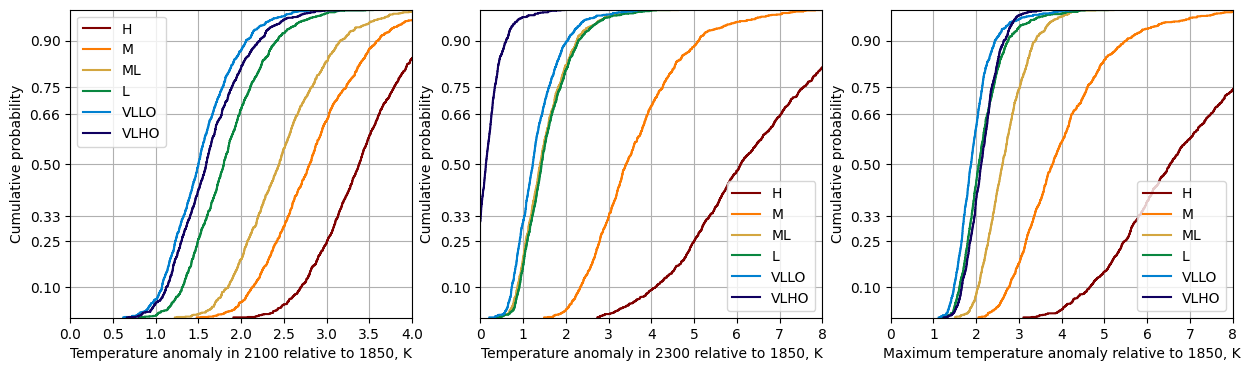

In [50]:
fig, ax = pl.subplots(1,3,figsize=(15,4))
ax=ax.flatten()

for scenario in f21c:
    a=ax[0].ecdf(f.temperature.sel(scenario=scenario, layer=0, timebounds=2100)-f.temperature.sel(scenario=scenario, layer=0, timebounds=1850),color=colors[scenario],label=ldict21[scenario])
ax[0].set_xlabel('Temperature anomaly in 2100 relative to 1850, K')
ax[0].set_ylabel('Cumulative probability')
ax[0].set_yticks([0.1,0.25,0.33,0.5,0.66,0.75,0.9])
ax[0].set_xticks([0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])
ax[0].set_xlim([0,4])
ax[0].legend()
ax[0].grid()


for scenario in f21c:
    a=ax[1].ecdf(f.temperature.sel(scenario=scenario, layer=0, timebounds=2300)-f.temperature.sel(scenario=scenario, layer=0, timebounds=1850),color=colors[scenario],label=ldict21[scenario])
ax[1].set_xlabel('Temperature anomaly in 2300 relative to 1850, K')
ax[1].set_ylabel('Cumulative probability')
ax[1].set_yticks([0.1,0.25,0.33,0.5,0.66,0.75,0.9])
ax[1].set_xticks(np.array([0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])*2)
ax[1].set_xlim([0,8])
ax[1].legend()
ax[1].grid()


for scenario in f21c:
    a=ax[2].ecdf(f.temperature.sel(scenario=scenario, layer=0).max(dim='timebounds')-f.temperature.sel(scenario=scenario, layer=0, timebounds=1850),color=colors[scenario],label=ldict21[scenario])
ax[2].set_xlabel('Maximum temperature anomaly relative to 1850, K')
ax[2].set_ylabel('Cumulative probability')
ax[2].set_yticks([0.1,0.25,0.33,0.5,0.66,0.75,0.9])
ax[2].set_xticks(np.array([0,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0])*2)
ax[2].set_xlim([0,8])
ax[2].legend()
ax[2].grid()


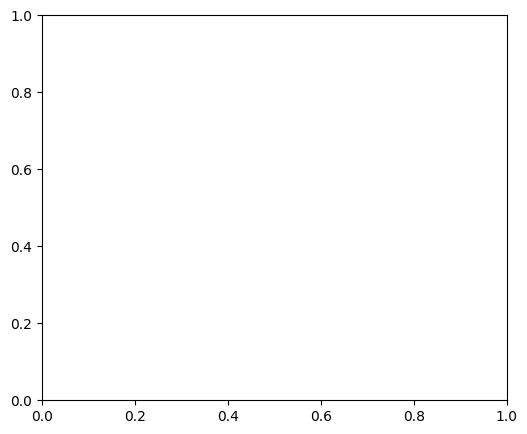

In [51]:
fig, ax = pl.subplots(1,1,figsize=(6,5))







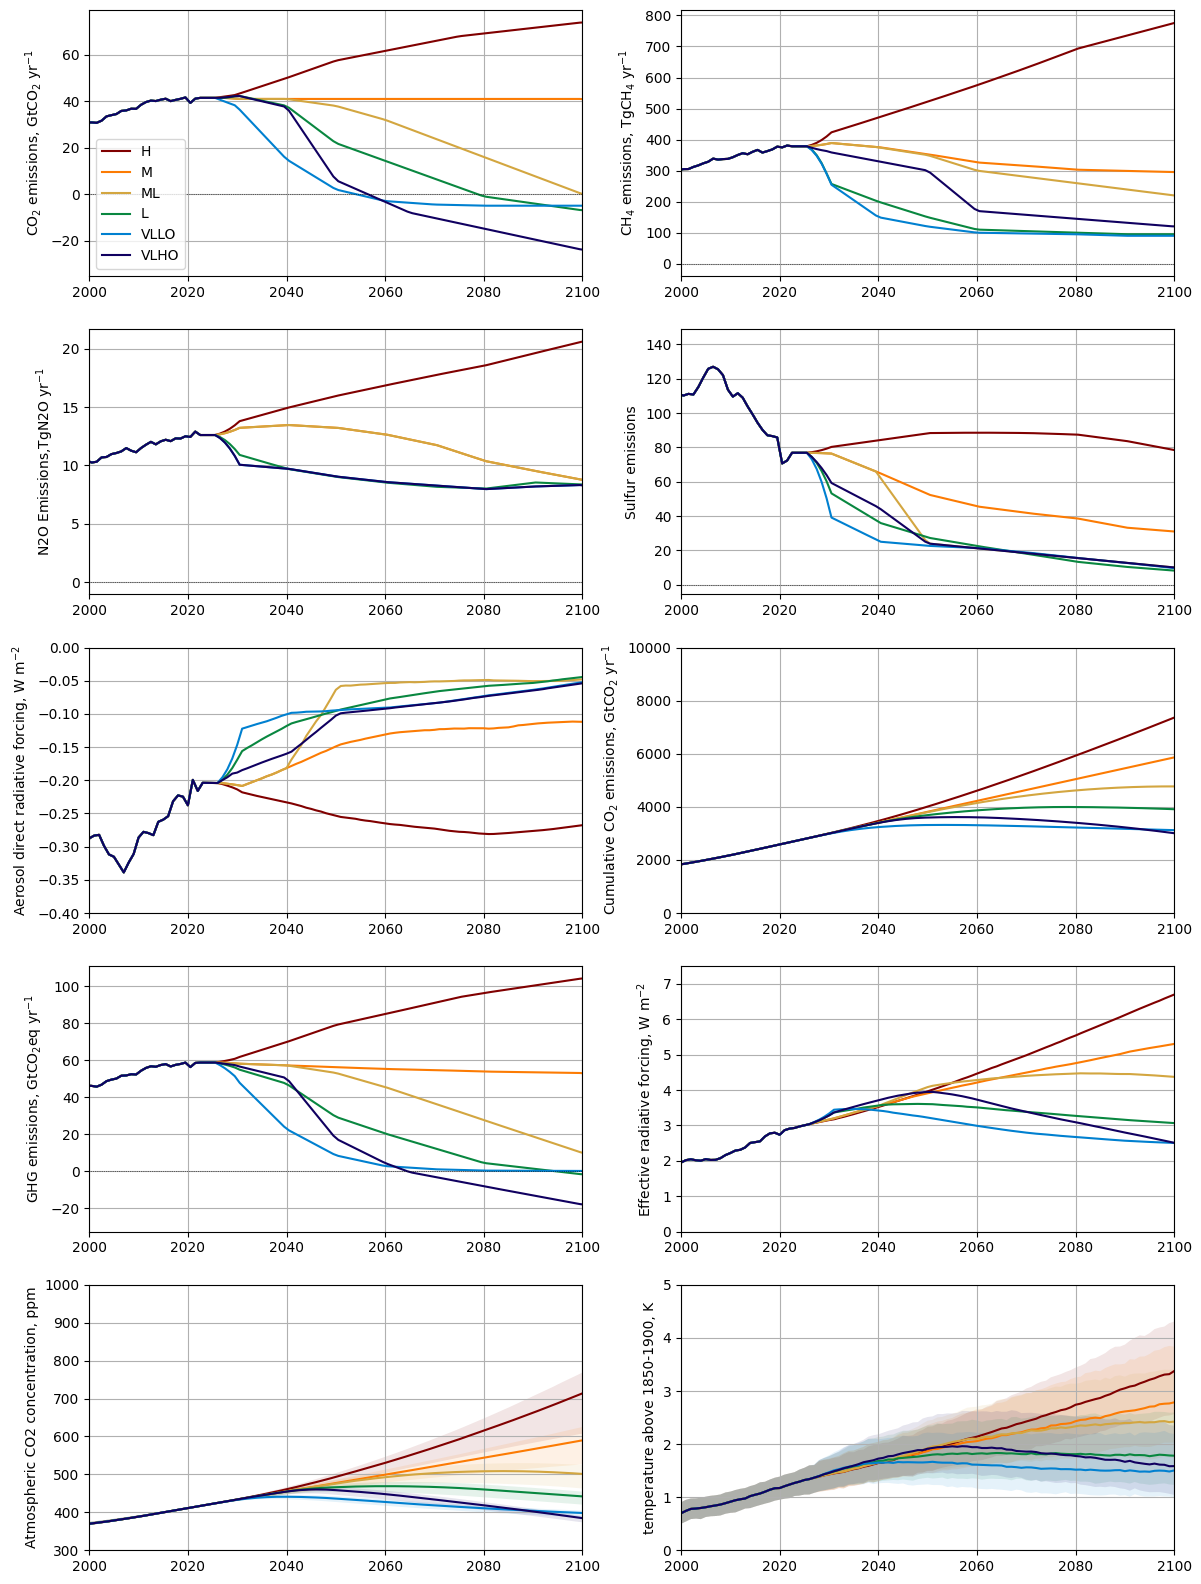

In [52]:
fig, ax = pl.subplots(nrows=5,ncols=2,figsize=(14,20))
ax=ax.flatten()
for scenario in f21c:
    ax[0].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[0].set_ylabel("CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
ax[0].legend()
ax[0].grid()
ax[0].set_xlim(2000, 2100)

for scenario in f21c:
    ax[1].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CH4", config=f.configs[0]) 
        ),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[1].set_ylabel("CH$_4$ emissions, TgCH$_4$ yr$^{-1}$")
ax[1].axhline(ls=':', color='k', lw=0.5)

ax[1].grid()
ax[1].set_xlim(2000, 2100)

for scenario in f21c:
    ax[2].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="N2O", config=f.configs[0]) 
        ),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[2].set_ylabel("N2O Emissions,TgN2O yr$^{-1}$")
ax[2].axhline(ls=':', color='k', lw=0.5)
#ax[2].legend()
ax[2].grid()
ax[2].set_xlim(2000, 2100)


for scenario in f21c:
    ax[3].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="Sulfur", config=f.configs[0]) 
        ),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[3].set_ylabel("Sulfur emissions",)
ax[3].axhline(ls=':', color='k', lw=0.5)
#ax[2].legend()
ax[3].grid()
ax[3].set_xlim(2000, 2100)

for scenario in f21c:
    ax[4].plot(
        f.timebounds,
        f.forcing.sel(scenario=scenario,specie='Aerosol-radiation interactions').median(dim='config'),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[4].set_ylabel('Aerosol direct radiative forcing, W m$^{-2}$')
#pl.legend();
ax[4].grid()
ax[4].set_xlim(2000, 2100)
ax[4].set_ylim(-.4, 0)




for scenario in f21c:
    ax[5].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ).cumsum(),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[5].set_ylabel("Cumulative CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[5].axhline(ls=':', color='k', lw=0.5)
#ax[1].legend()
ax[5].grid()
ax[5].set_xlim(2000, 2100)
ax[5].set_ylim(0, 10000)

for scenario in f21c:
    ax[6].plot(
        f.timepoints,
        co2e.sel(scenario=scenario)/ 1e6,
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[6].set_ylabel("GHG emissions, GtCO$_2$eq yr$^{-1}$")
ax[6].axhline(ls=':', color='k', lw=0.5)
#ax[2].legend()
ax[6].grid()
ax[6].set_xlim(2000, 2100)


for scenario in f21c:
    ax[7].plot(
        f.timebounds,
        f.forcing_sum.sel(scenario=scenario).median(dim='config'),
        label=ldict21[scenario],
        color=colors[scenario]
    )
ax[7].set_ylabel('Effective radiative forcing, W m$^{-2}$')
#pl.legend();
ax[7].grid()
ax[7].set_xlim(2000, 2100)
ax[7].set_ylim(0, 7.5)

for scenario in f21c:
    ax[8].fill_between(
        f.timebounds,
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario, )
        ).quantile(0.05, dim='config'),
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario)
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.1
    )
    ax[8].plot(
        f.timebounds,
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario)
        ).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax[8].axhline(0, ls=':', color='k', lw=0.5)
ax[8].set_ylabel('Atmospheric CO2 concentration, ppm')
ax[8].set_ylim(0,2000)
ax[8].grid()
ax[8].set_xlim(2000, 2100)
ax[8].set_ylim(300, 1000)
for scenario in f21c:
    ax[9].fill_between(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.05, dim='config'),
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.1
    )
    ax[9].plot(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax[9].axhline(0, ls=':', color='k', lw=0.5)
ax[9].set_ylabel('temperature above 1850-1900, K')
ax[9].set_ylim(-1, 11)
ax[9].grid()
ax[9].set_xlim(2000, 2100)
ax[9].set_ylim(0, 5)


pl.savefig('../plots/extensions.png')

In [53]:
# Jarmo's test
# but dump to "output" rather than "data"
f.emissions.sel(specie=["CO2 FFI", "CO2 AFOLU"], config=f.configs[0]).to_dataframe(name='value').reset_index().to_csv('../output/extensions_1750-2500_visualised_co2.csv', index=False)
f.emissions.sel(config=f.configs[0]).to_dataframe(name='value').reset_index().to_csv('../output/extensions_1750-2500_visualised.csv', index=False)